In [25]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
torch.set_default_device('cpu')

In [27]:
words = open('names.txt','r').read().splitlines()
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

In [28]:
#--------------------made cleaner---------------------------
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr.shape, Ytr.shape

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


(torch.Size([182625, 3]), torch.Size([182625]))

In [29]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 64))
W1 = torch.randn((3*64, 64))
b1 = torch.randn(64)
W2 = torch.randn((64, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

In [30]:
sum(p.nelement() for p in parameters) # total number of parameters

15835

In [31]:
for p in parameters:
    p.requires_grad = True

In [32]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [33]:
lri = []
lossi = []
stepi = []

In [34]:
for i in range(200000):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 3*64) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.883325457572937


In [35]:
loss.item()

1.883325457572937

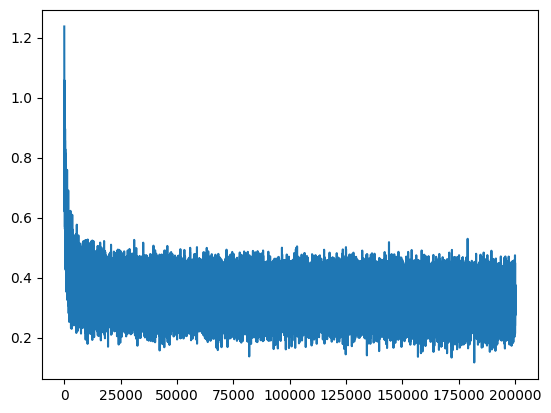

In [36]:
plt.plot(stepi, lossi)

In [37]:
#model loss pn dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 3*64) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1825, grad_fn=<NllLossBackward0>)

In [38]:
#model loss pn test set
emb = C[Xte]
h = torch.tanh(emb.view(-1, 3*64) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss
# dev loss and test loss roughly the same. underfitting the model. more performace by increasing the number of parameter

tensor(2.1786, grad_fn=<NllLossBackward0>)

In [39]:
#sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
ndhayla.
rethruthadrie.
cadered.
eliah.
milopi.
eden.
vananarielle.
malkelin.
shubergiag.
jest.
jair.
jenelle.
pucoul.
zayven.
jamyleyel.
yuma.
masko.
